# preparation

In [11]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

from torch.profiler import profile, record_function, ProfilerActivity

In [12]:
DEVICE = "cuda"
BATCH_SIZE = 4
DATA_PATH = "/content/drive/MyDrive/hymenoptera_data/"
TESTDATA_PATH  = "/content/drive/MyDrive/hymenoptera_data/val/"
BASE_MODEL_PATH = "/content/drive/MyDrive/CNNOptimized.pth"
BEST_MODEL_PATH = "/content/drive/MyDrive/CNNPrunedGO"

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# image transformer
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

testset = torchvision.datasets.ImageFolder(TESTDATA_PATH, transform=data_transforms['val'])
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=4)

# define function

In [15]:
def test_model(model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the validation images: {(100 * correct / total):.4f} %')

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        # save best model to local for further reuse
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    return model

In [17]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

# main function

load base model

In [20]:
# initialize
model = models.alexnet()

num_ftrs = model.classifier[-1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.classifier[-1] = nn.Linear(num_ftrs, 2)

# load base model
model.load_state_dict(torch.load(BASE_MODEL_PATH, map_location=DEVICE))

model = model.to(DEVICE)

In [21]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True) as prof:
    test_model(model)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=100))

Accuracy of the network on the validation images: 91.5033 %
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        74.14%       27.402s        74.15%       27.403s     668.370ms      90.15 Mb      90.15 Mb           0 b           0 b            41  
                                           aten::conv2d         0.01%       2.809ms        25.27%        9.340s      47.896ms           0 b        

prune the whole base model

In [22]:
for name, module in model.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.random_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.random_unstructured(module, name='weight', amount=0.4)

inference

Accuracy of the network on the validation images: 69.2810 %
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        73.36%        1.639s        73.41%        1.640s      39.999ms            41  
                                        cudaMemcpyAsync        14.48%     323.545ms        14.48%     323.545ms       2.765ms           117  
                                             aten::item         0.01%     222.000us        12.24%     273.357ms       6.667ms            41  
                              aten::_local_scalar_dense         0.02%     544.000us     

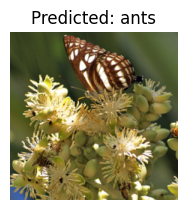

In [23]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    test_model(model)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=100))

visualize_model_predictions(
    model,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

retrain the model

In [24]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.6200 Acc: 0.7418
val Loss: 0.5626 Acc: 0.8431

Epoch 1/29
----------
train Loss: 0.5344 Acc: 0.7992
val Loss: 0.4984 Acc: 0.8366

Epoch 2/29
----------
train Loss: 0.4811 Acc: 0.8484
val Loss: 0.4435 Acc: 0.8562

Epoch 3/29
----------
train Loss: 0.4540 Acc: 0.8074
val Loss: 0.3821 Acc: 0.8301

Epoch 4/29
----------
train Loss: 0.3846 Acc: 0.8607
val Loss: 0.3597 Acc: 0.8431

Epoch 5/29
----------
train Loss: 0.3372 Acc: 0.8770
val Loss: 0.3419 Acc: 0.8824

Epoch 6/29
----------
train Loss: 0.3380 Acc: 0.8648
val Loss: 0.3207 Acc: 0.8824

Epoch 7/29
----------
train Loss: 0.3125 Acc: 0.8770
val Loss: 0.3122 Acc: 0.8693

Epoch 8/29
----------
train Loss: 0.3184 Acc: 0.8730
val Loss: 0.3083 Acc: 0.8824

Epoch 9/29
----------
train Loss: 0.3018 Acc: 0.8811
val Loss: 0.3077 Acc: 0.8758

Epoch 10/29
----------
train Loss: 0.2904 Acc: 0.8730
val Loss: 0.3074 Acc: 0.8693

Epoch 11/29
----------
train Loss: 0.3059 Acc: 0.8566
val Loss: 0.3117 Acc: 0.8889

Ep

inference

In [25]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True) as prof:
    test_model(model)
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=100))

Accuracy of the network on the validation images: 88.8889 %
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        73.11%        1.007s        73.22%        1.008s      24.591ms      94.75 Mb      94.75 Mb           0 b           0 b            41  
                                        cudaMemcpyAsync        17.06%     234.920ms        17.06%     234.920ms       2.008ms           0 b        

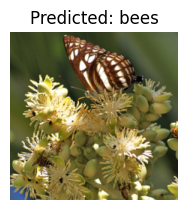

In [26]:
visualize_model_predictions(
    model,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()